##### 🟠 Scenario 2: Low Churn / Highly Imbalanced (Churn < 10%)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    recall_score,
    ConfusionMatrixDisplay
)

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


# Plot style
sns.set_theme(style="whitegrid")


In [29]:
# load dataset with low churn rate
df = pd.read_csv("../data/user_activity_lowchurn.csv")
df.head()


,customer_id,signup_days_ago,last_active_days_ago,num_logins_last_month,avg_session_length,num_support_tickets,is_premium,churned
0,1,594,264,2,21.98,0,0,0
1,2,843,147,3,16.02,0,0,1
2,3,74,183,2,11.49,0,0,0
3,4,806,226,6,19.92,1,0,0
4,5,803,291,5,21.95,0,1,0


In [30]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            1000 non-null   int64  
 1   signup_days_ago        1000 non-null   int64  
 2   last_active_days_ago   1000 non-null   int64  
 3   num_logins_last_month  1000 non-null   int64  
 4   avg_session_length     1000 non-null   float64
 5   num_support_tickets    1000 non-null   int64  
 6   is_premium             1000 non-null   int64  
 7   churned                1000 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 62.6 KB


,customer_id,signup_days_ago,last_active_days_ago,num_logins_last_month,avg_session_length,num_support_tickets,is_premium,churned
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,524.002000,149.459000,5.016000,14.950130,0.510000,0.289000,0.093000
std,288.819436,286.758778,86.655626,2.213288,4.914506,0.688748,0.453525,0.290578
min,1.000000,30.000000,0.000000,0.000000,-0.680000,0.000000,0.000000,0.000000
25%,250.750000,270.750000,73.000000,3.000000,11.657500,0.000000,0.000000,0.000000
50%,500.500000,543.500000,145.000000,5.000000,14.745000,0.000000,0.000000,0.000000
75%,750.250000,775.250000,225.000000,6.000000,18.162500,1.000000,1.000000,0.000000
max,1000.000000,998.000000,299.000000,13.000000,28.320000,4.000000,1.000000,1.000000


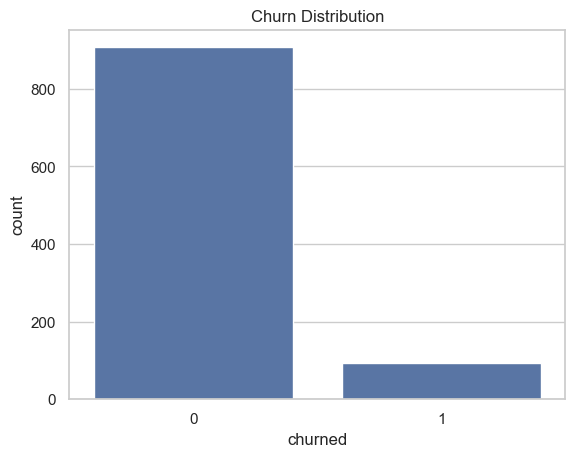

In [31]:
# Quick EDA

sns.countplot(x="churned", data=df)
plt.title("Churn Distribution")
plt.show()


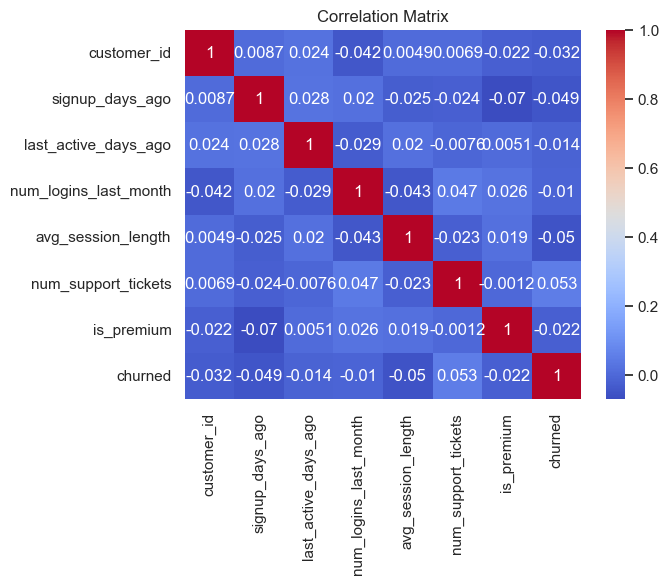

In [32]:
# check correlation

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [33]:
# feature prep

X = df.drop(columns=["customer_id", "churned"])
y = df["churned"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


✅ Recommended Baseline Model:

In [34]:
model = make_pipeline(
    SMOTE(random_state=42),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)

model.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [35]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("PR AUC:", average_precision_score(y_test, y_proba)) # Precision-Recall AUC becomes important now, 
                                                           # keep an eye out for false positives -- you don't
                                                           # wanna annoy loyal customers with churn warnings
                                                           # Optional threshold tuning later

              precision    recall  f1-score   support

           0       0.88      0.49      0.63       181
           1       0.07      0.37      0.12        19

    accuracy                           0.48       200
   macro avg       0.48      0.43      0.37       200
weighted avg       0.80      0.48      0.58       200

Confusion Matrix:
 [[89 92]
 [12  7]]
ROC AUC: 0.40389648153533003
Precision: 0.0707070707070707
Recall: 0.3684210526315789
F1 Score: 0.11864406779661017
PR AUC: 0.08249747171676286


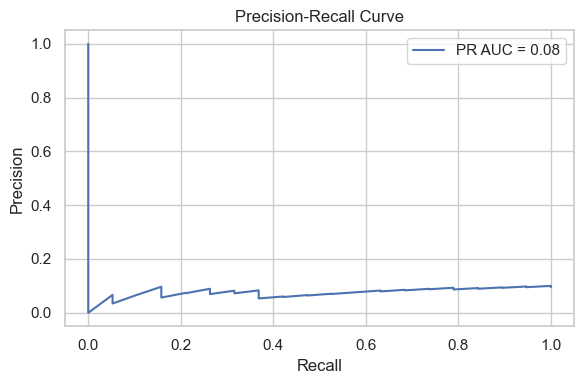

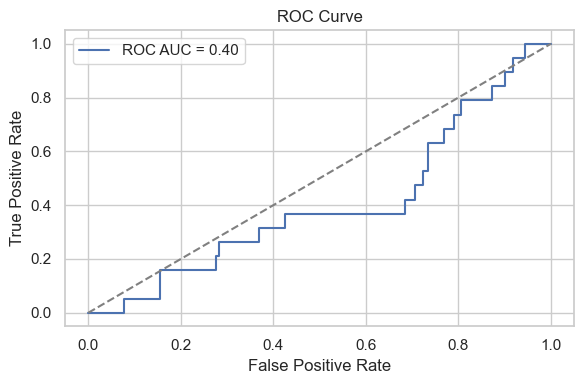

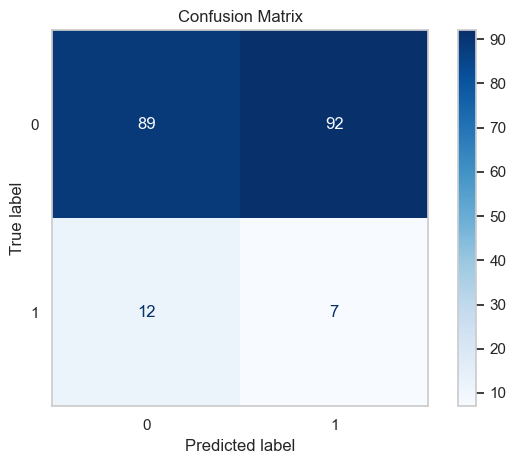

In [36]:
# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR AUC = {average_precision_score(y_test, y_proba):.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


🔧 __Optional: Adjust Threshold__  
If you want to manually set a threshold to be more aggressive catching churners:

In [37]:
y_pred_custom = (y_proba >= 0.3).astype(int)  # Lower threshold

print("Recall (threshold 0.3):", recall_score(y_test, y_pred_custom))


Recall (threshold 0.3): 0.631578947368421


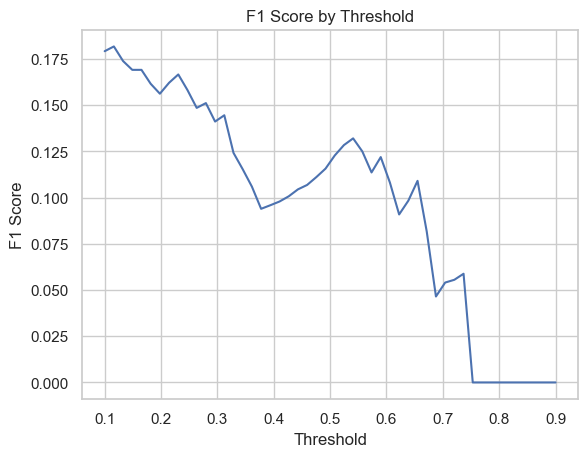

In [38]:
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

plt.plot(thresholds, f1_scores)
plt.title("F1 Score by Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()
